In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import ipywidgets
from IPython.display import display, clear_output, Javascript, Markdown

import poisson_clustering as ps

In [2]:
circuits, cable_config, partial_discharges, warning = ps.load_data()
circ = circuits[4]
print(circ)
# Lengte van de kabel is gegeven in de cable config
cable_length = cable_config[circ]['Cumulative length (m)'].values[-1]
pardis = partial_discharges[circ]

2806


In [3]:
boolean_series, locations, charges, times, bins = ps.identify_suspicious_areas(pardis, cable_length)

In [4]:
clusters = ps.cluster_boolean_series(boolean_series)
print(clusters)

{(275, 282), (211, 229)}


/home/rick/Documents/Universiteit/Wiskunde/Modellenpracticum/venv/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


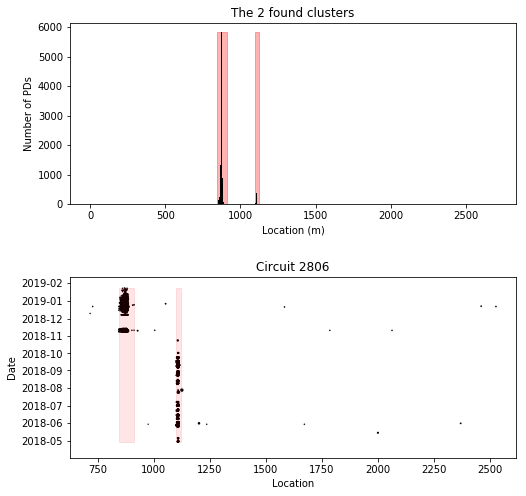

In [5]:
ps.show_plot(locations, times, charges, bins, clusters, circ)

In [6]:
clusters_meters = sorted([tuple(a*4.0 for a in x) for x in clusters], key=lambda x: x[0])
clusters_meters

[(844.0, 916.0), (1100.0, 1128.0)]

In [7]:
def normal_parameters(locations, clusters, circuit):
    result = []
    for current_cluster in clusters:
        min_location, max_location = current_cluster[0], current_cluster[1]
        cluster_bools = [min_location <= loc <= max_location for loc in locations] 
        cluster_pds = locations[cluster_bools]
        mu = np.mean(cluster_pds)
        sigma = np.std(cluster_pds)
        result.append((current_cluster, max_location-min_location, mu, sigma, cable_config[circuit]['Cumulative length (m)'].values[-1]))
    return result

In [8]:
normal_parameters(locations, clusters_meters, circ)

[((844.0, 916.0), 72.0, 873.5697521097876, 5.550966954094647, 2701.0),
 ((1100.0, 1128.0), 28.0, 1108.1367176121896, 1.6550244993312642, 2701.0)]

In [9]:
def calculate_all_normal_parameters():
    circuits, cable_config, partial_discharges, warning = ps.load_data()
    result = []
    for circ in circuits:
        # Lengte van de kabel is gegeven in de cable config
        cable_length = cable_config[circ]['Cumulative length (m)'].values[-1]
        pardis = partial_discharges[circ]
        boolean_series, locations, charges, times, bins = ps.identify_suspicious_areas(pardis, cable_length)
        clusters = ps.cluster_boolean_series(boolean_series)
        clusters_meters = [tuple(a*4.0 for a in x) for x in clusters]
        result.extend([tuple((circ,)) + x for x in normal_parameters(locations, clusters_meters, circ)])
    return result

In [10]:
parameters = calculate_all_normal_parameters()
len(parameters)

20

In [11]:
# Clusters die beginnen bij 0 of eindigen bij cable_length eruit filteren
# want we willen geen half afgehakte clusters, die altijd bij het uiteinde van de kabel optreedt
parameters = [x for x in parameters if x[1][0] != 0.0 and x[1][1] != x[5]]
len(parameters)

18

# Idee

Deel de clusters weer in in bins. Bepaal bij iedere kabel wat het niveau van ruis $\nu_{kabel}$: het aantal pds buiten de clusters, gedeeld door de lengte van de kabel (clusters niet meegeteld). Dit geeft aan hoeveel pds er gewoonlijk in een bin zitten. Binnen de clusters is dit aantal natuurlijk hoger: $\alpha_{bin}$. We gaan ervan uit dat de ruis binnen de clusters zich hetzelfde gedraagt als de ruis buiten de clusters (dwz: de ruis is over de gehele kabel uniform verdeeld).

Bereken $\Delta_{bin} = \alpha_{bin} - \nu_{kabel}$, het aantal pds in een bin binnen een cluster als er geen ruis was geweest.

De lopende hypthese is dat deze $\Delta_{bin}$ samen een normaalverdeling vormen. Dit kunnen we testen door er een normaalverdeling op te fitten.

In [12]:
def in_range(point, ranges):
    for ran in ranges:
        if(ran[0] <= point <= ran[1]):
            return True
    return False

def cluster_length(ranges):
    total = 0
    for ran in ranges:
        ran_length = ran[1]-ran[0]
        total += ran_length
    return total

def average_outside_clusters(circuits, partial_discharges, cable_config, parameters):
    """
    Calculates the average number of partial discharges per meter for each circuit
    
    Parameters
    ----------
    circuits: list
    circuit numbers of all circuits that are to be inspected
    
    partial_discharges: Series
    information about all partial discharges
    
    cable_config: Series
    cable configurations of all circuits (used for cable lengths)
    
    parameters: list
    list of tuples, with first element the circuit number and second element a cluster in meters (c_min, c_max)
    preferably use result of calculate_all_normal_parameters
    
    Returns
    -------
    result: dict
    dictionary with circuit numbers as keys and 
    average number of partial discharges outside clusters per meter as values
    """
    result = {}
    for circ in circuits:
        pardis = partial_discharges[circ]
        datetimes, locs, charges = pardis.columns
        clusters = [x[1] for x in parameters if x[0] == circ]
        if(clusters):
            in_cluster = [in_range(x, clusters) for x in pardis[locs]]
            outside_cluster = [not b for b in in_cluster]
            points_in_cluster = pardis[locs][in_cluster]
            points_outside_cluster = pardis[locs][outside_cluster]

            cable_length = cable_config[circ]['Cumulative length (m)'].values[-1]
            total_cluster_length = cluster_length(clusters)
            outside_cluster_length = cable_length - total_cluster_length

            average_outside_cluster = points_outside_cluster.count()/outside_cluster_length
            result[circ] = average_outside_cluster
    return result

In [13]:
aoc = average_outside_clusters(circuits, partial_discharges, cable_config, parameters)
aoc

{1512: 0.9850089946032381,
 2063: 1.9144334743770568,
 2145: 11.012406231967686,
 2806: 0.006151480199923107,
 2870: 5.97698504027618}

In [14]:
def determine_bins(cluster, pds):
    """
    Determine nice bin edges such that each bin contains exactly one "strip" of pds
    
    Parameters
    ----------
    cluster: tuple
    tuple of floats, indicating interval (x,y) in which cluster is contained
    
    pds: Series
    pandas series containing the pds in the cluster
    
    Returns: list
    list of bin edges [x_0, x_1, ..., x_n] such that (x_i, x_i+1) forms a bin
    """
    

def count_pds(circuits, partial_discharges, parameters, aoc):
    result = []
    for circ in circuits:
        pardis = partial_discharges[circ]
        datetimes, locs, charges = pardis.columns
        clusters = [x[1] for x in parameters if x[0] == circ]
        for cluster in clusters:
            in_cluster = [in_range(x, [cluster]) for x in pardis[locs]]
            pds_in_cluster = pardis[locs][in_cluster]
            rounded_pds = pds_in_cluster.apply(round)
            bins = np.arange(start=cluster[0], stop=cluster[1], step=1)
            binned_pds, _ = np.histogram(rounded_pds, bins)
            filtered_bins = [x for x in bins if binned_pds[np.where(bins == x)[0]-1] > aoc[circ]]
            filtered_pds = [int(round(x-aoc[circ])) for x in binned_pds if x > aoc[circ]]
            result.append((circ, cluster, filtered_pds, filtered_bins))
    return result

| Circuit | Cluster | Number of pds | Location (m) |
|---------|---------|---------------|--------------|
| 2145 | (928.0, 968.0) | [358, 1234, 2576, 3536, 3340, 2453, 1283, 446, 177] | [928.0, 931.0, 935.0, 938.0, 943.0, 948.0, 953.0, 958.0, 963.0, 967.0] |
| 2145 | (864.0, 904.0) | [113, 133, 246, 261, 337, 357, 452, 426, 449, 380, 232, 141] | [864.0, 867.0, 870.0, 873.0, 877.0, 880.0, 884.0, 887.0, 890.0, 894.0, 897.0, 901.0, 903.0] |
| 2806 | (1100.0, 1128.0) | [2, 23, 102, 289, 473, 3, 1, 1] | [1100.0, 1103.0, 1105.0, 1107.0, 1108.0, 1110.0, 1111.0, 1119.0, 1127.0] |
| 2806 | (844.0, 916.0) | [4, 15, 25, 39, 84, 149, 258, 454, 863, 1636, 2694, 3155, 1901, 692, 194, 55, 8, 1, 1, 1, 2] | [845.0, 848.0, 851.0, 854.0, 857.0, 860.0, 863.0, 865.0, 868.0, 871.0, 874.0, 877.0, 880.0, 883.0, 884.0, 886.0, 888.0, 890.0, 904.0, 908.0, 914.0] |
| 2870 | (976.0, 988.0) | [94, 109, 164, 111, 84, 104] | [976.0, 977.0, 979.0, 981.0, 983.0, 985.0, 987.0] |
| 2870 | (928.0, 948.0) | [27, 26, 34, 48, 27, 45, 24, 45, 23, 17] | [928.0, 930.0, 932.0, 934.0, 936.0, 938.0, 940.0, 941.0, 943.0, 945.0, 947.0] |
| 2870 | (1256.0, 1272.0) | [13, 39, 60, 82, 37, 43, 78, 64, 43, 18] | [1256.0, 1257.0, 1259.0, 1261.0, 1263.0, 1264.0, 1265.0, 1266.0, 1268.0, 1270.0, 1271.0] |
| 2870 | (756.0, 784.0) | [38, 68, 77, 101, 124, 145, 185, 259, 432, 660, 709, 451, 249, 87, 34] | [756.0, 757.0, 759.0, 761.0, 763.0, 765.0, 767.0, 768.0, 770.0, 772.0, 774.0, 776.0, 778.0, 780.0, 782.0, 783.0] |
| 2870 | (364.0, 396.0) | [39, 51, 71, 170, 319, 494, 826, 1122, 1458, 1621, 1548, 1253, 876, 472, 208, 58, 32] | [364.0, 366.0, 368.0, 370.0, 371.0, 373.0, 375.0, 377.0, 379.0, 381.0, 383.0, 385.0, 386.0, 388.0, 390.0, 392.0, 394.0, 395.0] |
| 1512 | (1296.0, 1328.0) | [57, 1, 136, 238, 445, 663, 893, 1082, 1205, 1204, 1128, 940, 759, 600, 473, 291, 192, 121, 65, 42, 20, 16] | [1296.0, 1298.0, 1299.0, 1300.0, 1301.0, 1302.0, 1304.0, 1305.0, 1307.0, 1308.0, 1310.0, 1311.0, 1313.0, 1314.0, 1316.0, 1317.0, 1319.0, 1320.0, 1322.0, 1323.0, 1325.0, 1326.0, 1327.0] |
| 1512 | (776.0, 800.0) | [3, 10, 6, 1, 6, 16, 4, 11, 14, 7, 12, 18, 12, 16, 21, 21, 0, 23, 12, 14, 9] | [776.0, 777.0, 779.0, 780.0, 781.0, 782.0, 783.0, 784.0, 785.0, 786.0, 787.0, 788.0, 789.0, 790.0, 791.0, 792.0, 793.0, 794.0, 795.0, 796.0, 798.0, 799.0] |
| 1512 | (348.0, 376.0) | [11, 8, 7, 7, 4, 6, 2, 6, 8, 6, 1, 4, 6, 3, 4, 2, 0, 7, 1, 38] | [348.0, 350.0, 351.0, 353.0, 354.0, 356.0, 357.0, 359.0, 360.0, 362.0, 363.0, 364.0, 365.0, 366.0, 367.0, 369.0, 370.0, 371.0, 372.0, 373.0, 375.0] |
| 1512 | (812.0, 836.0) | [1016, 442, 961, 1279, 1355, 1264, 1015, 735, 449, 297, 167, 108, 64, 38, 24, 11] | [812.0, 814.0, 815.0, 816.0, 818.0, 819.0, 821.0, 822.0, 824.0, 825.0, 827.0, 828.0, 830.0, 831.0, 833.0, 834.0, 835.0] |
| 1512 | (848.0, 872.0) | [8, 19, 20, 30, 44, 39, 69, 76, 68, 64, 53, 54, 49, 23, 16] | [848.0, 850.0, 852.0, 853.0, 855.0, 856.0, 858.0, 859.0, 861.0, 862.0, 864.0, 865.0, 867.0, 868.0, 870.0, 871.0] |
| 2063 | (492.0, 544.0) | [12, 12, 9, 7, 13, 22, 22, 16, 29, 41, 48, 50, 61, 68, 70, 70, 68, 51, 49, 26, 27, 22] | [494.0, 496.0, 498.0, 501.0, 503.0, 505.0, 508.0, 510.0, 512.0, 515.0, 517.0, 519.0, 522.0, 524.0, 526.0, 529.0, 531.0, 533.0, 536.0, 538.0, 540.0, 542.0] |
| 2063 | (256.0, 288.0) | [13, 1, 8, 0, 15, 12, 16, 3, 22, 29, 0, 13, 19, 15, 12, 12, 14, 4] | [256.0, 257.0, 258.0, 260.0, 261.0, 262.0, 264.0, 267.0, 268.0, 269.0, 271.0, 272.0, 273.0, 276.0, 278.0, 280.0, 283.0, 285.0, 287.0] |
| 2063 | (328.0, 364.0) | [15, 15, 33, 63, 94, 0, 137, 1, 155, 202, 0, 236, 231, 237, 235, 0, 179, 135, 0, 70, 35] | [328.0, 329.0, 331.0, 334.0, 336.0, 338.0, 340.0, 341.0, 342.0, 343.0, 345.0, 347.0, 348.0, 350.0, 352.0, 355.0, 356.0, 357.0, 359.0, 361.0, 362.0, 363.0] |
| 2063 | (576.0, 628.0) | [24, 26, 28, 37, 0, 54, 76, 106, 169, 202, 316, 436, 624, 819, 961, 2, 878, 848, 0, 506, 274, 122, 40, 24, 11, 9] | [576.0, 577.0, 580.0, 582.0, 584.0, 586.0, 587.0, 589.0, 591.0, 594.0, 596.0, 598.0, 600.0, 603.0, 605.0, 607.0, 608.0, 610.0, 612.0, 613.0, 614.0, 617.0, 619.0, 621.0, 624.0, 626.0, 627.0] |

In [15]:
pd_counts = count_pds(circuits, partial_discharges, parameters, aoc)
#For result see above

In [90]:
from scipy.stats import norm, chisquare

for i in range(len(pd_counts)):
    current = pd_counts[i]
    pds = []
    for count in current[2]:
        count_pds = [current[3][current[2].index(count)]] * count
        pds.extend(count_pds)
    mu, std = norm.fit(pds)
    p = norm.pdf(np.linspace(pds[0], pds[-1], len(current[2])), mu, std)
    pd_sum = sum(current[2])
    normal_sum = sum(p)
    p_rescaled = [int(round(x*(pd_sum/normal_sum))) for x in p]
    chisquaretest = chisquare(current[2], f_exp=p_rescaled)

    print(str(current[0:2]) + " " + str(chisquaretest[0:2]))

(2145, (928.0, 968.0)) (1201.857996409993, 3.804873408267078e-254)
(2145, (864.0, 904.0)) (208.8739845576277, 1.0678611633766369e-38)
(2806, (1100.0, 1128.0)) (inf, 0.0)
(2806, (844.0, 916.0)) (inf, 0.0)
(2870, (976.0, 988.0)) (106.81561623641797, 1.92838602415481e-21)
(2870, (928.0, 948.0)) (51.27131819225522, 6.206181208485783e-08)
(2870, (1256.0, 1272.0)) (124.79782407194597, 1.3887333409570565e-22)
(2870, (756.0, 784.0)) (837.2229475985763, 1.199874253932289e-169)
(2870, (364.0, 396.0)) (290.21177639791665, 2.7039211828809476e-52)
(1512, (1296.0, 1328.0)) (277.45783892717753, 1.1956664186562447e-46)
(1512, (776.0, 800.0)) (200.70767895675016, 8.152186586118494e-32)
(1512, (348.0, 376.0)) (449.640873015873, 1.9605426449046172e-83)
(1512, (812.0, 836.0)) (1295.545149615655, 4.813179828235367e-267)
(1512, (848.0, 872.0)) (37.43752273589826, 0.0006331629565296385)
(2063, (492.0, 544.0)) (196.14925326459192, 2.0697454554344963e-30)
(2063, (256.0, 288.0)) (375.89448621553885, 2.000837746

/home/rick/Documents/Universiteit/Wiskunde/Modellenpracticum/venv/lib/python3.5/site-packages/scipy/stats/stats.py:4653: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


# Resultaten

| Cluster | Chi Square Result |
|---------|-------------------|
| (2145, (928.0, 968.0)) | (1201.857996409993, 3.804873408267078e-254) |
| (2145, (864.0, 904.0)) | (208.8739845576277, 1.0678611633766369e-38) |
| (2806, (1100.0, 1128.0)) | (inf, 0.0) |
| (2806, (844.0, 916.0)) | (inf, 0.0) |
| (2870, (976.0, 988.0)) | (106.81561623641797, 1.92838602415481e-21) |
| (2870, (928.0, 948.0)) | (51.27131819225522, 6.206181208485783e-08) |
| (2870, (1256.0, 1272.0)) | (124.79782407194597, 1.3887333409570565e-22) |
| (2870, (756.0, 784.0)) | (837.2229475985763, 1.199874253932289e-169) |
| (2870, (364.0, 396.0)) | (290.21177639791665, 2.7039211828809476e-52) |
| (1512, (1296.0, 1328.0)) | (277.45783892717753, 1.1956664186562447e-46) |
| (1512, (776.0, 800.0)) | (200.70767895675016, 8.152186586118494e-32) |
| (1512, (348.0, 376.0)) | (449.640873015873, 1.9605426449046172e-83) |
| (1512, (812.0, 836.0)) | (1295.545149615655, 4.813179828235367e-267) |
| (1512, (848.0, 872.0)) | (37.43752273589826, 0.0006331629565296385) |
| (2063, (492.0, 544.0)) | (196.14925326459192, 2.0697454554344963e-30) |
| (2063, (256.0, 288.0)) | (375.89448621553885, 2.0008377464439513e-69) |
| (2063, (328.0, 364.0)) | (870.6759542632848, 1.3609615749281226e-171) |
| (2063, (576.0, 628.0)) | (2749.7455255102514, 0.0) |

De resultaten zijn nogal slecht. Een erg lage confidence bij alle clusters. Waarschijnlijk komt dit door een fout in hoe de pds worden verdeeld over de bins.

In [143]:
from scipy.stats import truncnorm

for circ in circuits:
    clusters = [x[1] for x in parameters if x[0] == circ]
    for cluster in clusters:
        pds = partial_discharges[circ]
        _, locs, _ = pds.columns
        in_cluster = [in_range(x, [cluster]) for x in pds[locs]]
        pds_in_cluster = pds[locs][in_cluster]
        rounded_pds = pds_in_cluster.apply(lambda x: round(x, 2))
        sorted_pds = sorted(rounded_pds)
        values = []
        while sorted_pds:
            x_min = sorted_pds[0]
            equal_pds = [x for x in sorted_pds if abs(x - x_min) < 0.3]
            values.append((x_min, len(equal_pds)))
            sorted_pds = [x for x in sorted_pds if abs(x - x_min) > 0.3]
        values = [[x[0], int(round(max(x[1]-aoc[circ], 0)))] for x in values]
        pds_without_noise = []
        for i in range(len(values)):
            pds_without_noise.extend([values[i][0]] * values[i][1])
        mu, std = norm.fit(pds_without_noise)
        values_transposed = np.array(values).T.tolist()
        p = truncnorm.pdf([x-mu for x in values_transposed[0]], cluster[0]-mu, cluster[1]-mu, loc=0, scale=std)
        #p = norm.pdf(values_transposed[0], mu, std)
        pd_max = max(values_transposed[1])
        vt1 = values_transposed[1]
        m = [x*(sum(vt1)/sum(p)) for x in p]
        chisquaretest = chisquare(vt1, f_exp=m)
        print(circ, cluster, chisquaretest[0:2])

2145 (928.0, 968.0) (347.94009825961587, 2.492012722231578e-70)
2145 (864.0, 904.0) (197.58567143417244, 2.3564383815282197e-36)
2806 (1100.0, 1128.0) (1.5939518512413394e+22, 0.0)
2806 (844.0, 916.0) (123842074.75003444, 0.0)
2870 (976.0, 988.0) (55.63706542164539, 3.446681041262846e-10)
2870 (928.0, 948.0) (41.82787900135165, 8.046320376220826e-06)
2870 (1256.0, 1272.0) (10.713987915110756, 0.21843752499983896)
2870 (756.0, 784.0) (864.5272840726266, 1.711990827763046e-175)
2870 (364.0, 396.0) (292.401909836267, 9.530296306250542e-53)
1512 (1296.0, 1328.0) (155.7156857962699, 5.026640000478441e-23)
1512 (776.0, 800.0) (23.640330586288307, 0.09765968152799041)
1512 (348.0, 376.0) (218.14270926720562, 8.123061809984623e-36)
1512 (812.0, 836.0) (1172.2634005634932, 1.333465165752072e-239)
1512 (848.0, 872.0) (22.853909717708554, 0.08729126292181498)
2063 (492.0, 544.0) (95.66533015186266, 3.6562487868635954e-11)
2063 (256.0, 288.0) (198.44455728626772, 2.090691405369157e-29)
2063 (328.0